In [1]:
# make sure matplotlib shows images inline
%matplotlib inline

# import packages
import numpy as np
import time
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import os
import cv2

# Keras packages
from keras import layers
from keras.layers import Input,Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_uniform

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K

Using TensorFlow backend.


In [2]:
# set directory
os.chdir("D:/Documents/GitHub/HandSign_Recognition")

# set variables
nr_possible_values = 6 
# possible values are 0 1 2 3 4 5

In [3]:
# read the data
train_dataset = h5py.File('00 Data/train_signs.h5', "r")
train_x = np.array(train_dataset["train_set_x"][:]) # your train set features
train_y = np.array(train_dataset["train_set_y"][:]) # your train set labels

test_dataset = h5py.File('00 Data/test_signs.h5', "r")
test_x = np.array(test_dataset["test_set_x"][:]) # your test set features
test_y = np.array(test_dataset["test_set_y"][:]) # your test set labels

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print('\n')

#train_y = train_y.reshape((1, train_y.shape[0]))
#test_y = test_y.reshape((1, test_y.shape[0]))

#print(train_y.shape)
#print(test_y.shape)
#print('\n')

print(train_y)

(1080, 64, 64, 3)
(1080,)
(120, 64, 64, 3)
(120,)


[5 0 2 ..., 2 4 5]


In [ ]:
# reshape the y
#train_y = train_y.reshape((1080,))
#test_y = test_y.reshape((120,))

#print(train_y.shape)
#print(test_y.shape)

In [4]:
# create a matrice with only zeros
# the number of rows = the number of images
# the number of columns = the number of possible values we want to recognize
Y_train = np.zeros([1080, nr_possible_values])
Y_test = np.zeros([120, nr_possible_values])

# set the value of 1 for each record in the column with the corresponding value
# so if the label of the image is 5, the 1 will be set in the sixth column for that record
count = 0
for i in train_y:
    Y_train[count,i] = 1
    count = count + 1

count = 0
for  i in test_y:
    Y_test[count,i] = 1
    count = count + 1

In [5]:
# normalize the data (set all values between [0,1])
X_train = train_x / 255
X_test = test_x / 255

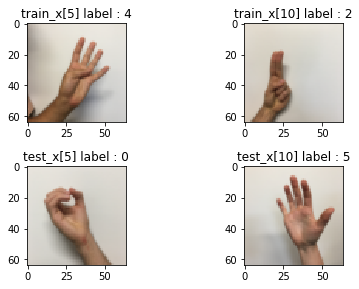

In [6]:
# take a look at a few of the images in the data
plt.subplots(2,2)
plt.subplots_adjust(top = 0.92, bottom = 0.08, left = 0.10, right = 0.95, hspace = 0.45, wspace = 0.45)

plt.subplot(2,2,1)
plt.title('train_x[5] label : ' + str(train_y[5]))
plt.imshow(train_x[5])
plt.subplot(2,2,2)
plt.title('train_x[10] label : ' + str(train_y[10]))
plt.imshow(train_x[10])

plt.subplot(2,2,3)
plt.title('test_x[5] label : ' + str(test_y[5]))
plt.imshow(test_x[5])
plt.subplot(2,2,4)
plt.title('test_x[10] label : ' + str(test_y[10]))
plt.imshow(test_x[10])

In [7]:
# make sure to tell keras the channels are the last dimension in the shape of the dataset
# in this case the channel = 3, since we have full color images with 3 RGB channels
K.set_image_data_format('channels_last')

In [8]:
def plain_layer(X,n_c):
    X_in = X
    X = Conv2D(n_c,kernel_size = (3,3), padding = 'same')(X_in)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size = (2,2))(X)
    return X

In [9]:
def identity_block(X,F):
    X_in = X
    
    F1,F2,F3 = F
    
    X = Conv2D(F1,kernel_size=(3,3),padding='same')(X_in)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2,kernel_size=(3,3),padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F3,kernel_size=(3,3),padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    
    X_in = Conv2D(F3,kernel_size=(3,3),padding='same')(X_in)
    X_in = BatchNormalization(axis=3)(X_in)
    
    X = Add()([X,X_in])
    X = Activation('relu')(X)
    
    return X

In [10]:
def Resnet(input_shape=(64,64,3),classes=6):
    X_in = Input(input_shape)
    
    X = plain_layer(X_in,32)
    
    F1 = [16,16,32]
    X = identity_block(X,F1)
    #X = MaxPooling2D(pool_size=(2,2))(X)
    
    F2 = [16,16,32]
    X = identity_block(X,F2)
    #X = MaxPooling2D(pool_size=(2,2))(X)
    
    F3 = [16,16,32]
    X = identity_block(X,F3)
    #X = MaxPooling2D(pool_size=(2,2))(X)
    
    #X = plain_layer(X,32)
    X = AveragePooling2D((2,2))(X)
    
    X = Flatten()(X)
    X = Dense(512,activation='relu')(X)
    X = Dense(128,activation='relu')(X)
    X = Dense(classes,activation='softmax')(X)
    
    model = Model(inputs=X_in,outputs=X,name='Resnet')
    return model

In [12]:
# declare a resnet model
my_model = Resnet()

# print the current date and time
print(time.ctime())

my_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
my_model.fit(x = X_train, y = Y_train, epochs = 20, batch_size = 32)

# print the current date and time
print(time.ctime())

time.sleep(5)

Sun Jan 28 10:57:17 2018
Epoch 1/20
1080/1080 [==============================] - 99s - loss: 10.3805 - acc: 0.3009    
Epoch 2/20
1080/1080 [==============================] - 93s - loss: 10.7459 - acc: 0.3333    
Epoch 3/20
1080/1080 [==============================] - 85s - loss: 10.7464 - acc: 0.3333    
Epoch 4/20
1080/1080 [==============================] - 86s - loss: 10.7767 - acc: 0.3269    
Epoch 5/20
1080/1080 [==============================] - 88s - loss: 11.0663 - acc: 0.3056    
Epoch 6/20
1080/1080 [==============================] - 95s - loss: 10.7873 - acc: 0.3287    
Epoch 7/20
1080/1080 [==============================] - 86s - loss: 10.7616 - acc: 0.3315    
Epoch 8/20
1080/1080 [==============================] - 85s - loss: 10.7631 - acc: 0.3306    
Epoch 9/20
1080/1080 [==============================] - 88s - loss: 10.7454 - acc: 0.3333    
Epoch 10/20
1080/1080 [==============================] - 87s - loss: 10.7454 - acc: 0.3333    
Epoch 11/20
1080/1080 [===========

In [13]:
my_model.evaluate(X_train, Y_train, batch_size = 32)

1080/1080 [==============================] - 39s    


[10.7453969390304, 0.3333333334437123]

In [14]:
pred = my_model.predict(X_test)
pred_label = np.argmax(pred,axis = 1)

In [15]:
print(classification_report(test_y, pred_label))

             precision    recall  f1-score   support

          0       0.34      1.00      0.51        20
          1       0.32      1.00      0.49        20
          2       0.00      0.00      0.00        20
          3       0.00      0.00      0.00        20
          4       0.00      0.00      0.00        20
          5       0.00      0.00      0.00        20

avg / total       0.11      0.33      0.17       120



D:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
print(test_y)
print(pred_label)

[0 0 0 5 1 0 3 1 5 1 5 1 3 1 1 3 5 4 0 4 5 4 2 5 3 5 4 2 1 2 3 1 0 3 1 1 0
 4 2 3 0 3 0 2 3 1 2 2 0 3 4 1 2 0 4 0 4 0 4 4 5 5 2 4 4 5 0 1 3 5 0 4 1 2
 3 4 3 5 1 5 2 0 1 4 2 4 4 1 4 5 5 0 0 5 5 5 3 3 5 2 2 2 0 2 5 3 0 2 3 4 1
 3 2 4 2 2 1 3 1 3]
[0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0
 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1
 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 0 1
 0 1 0 1 1 1 0 1 0]


In [17]:
# serialize model to JSON and save it
my_model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(my_model_json)

# serialize weights to HDF5
my_model.save_weights("my_model.h5")
print("Saved model to disk")

Saved model to disk
